# Wrangle and Analyze Data

The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10.

## Data Extraction and Gathering

In [3]:
#Importing libraries for cleaning and analyses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tweepy
import json
import re 
import datetime as dt
import seaborn as sns

In [4]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

### Gathering Data For Image Predictions File
- This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library.

In [11]:
#Requesting and downloading from link
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [12]:
#Loading the downloaded data to a tsv file
filename = 'image_predictions.tsv'
with open(filename,'wb') as fh:
    fh.write(response.content)

In [5]:
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')


In [4]:
twitter_archive_enhanced.shape

(2356, 17)

In [5]:
image_predictions.shape

(2075, 12)

### Data via the Twitter API
- Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.

In [6]:
#Twitter API Initialization
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [6]:
filename = 'tweet_json.txt'

In [184]:
#Loading json data to file as a list of jsons
last_id = twitter_archive_enhanced.tweet_id.iloc[-1]
with open(filename, 'w') as fh:
    fh.write('[')
    for tweet_id in twitter_archive_enhanced.tweet_id:
        try:
            data = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(data._json, fh)
            if tweet_id != last_id:
                fh.write(',')
        except:
            print("Failed for id :", tweet_id)
            continue
    fh.write(']')

Failed for id : 888202515573088257
Failed for id : 873697596434513921
Failed for id : 869988702071779329
Failed for id : 866816280283807744
Failed for id : 861769973181624320
Failed for id : 845459076796616705
Failed for id : 842892208864923648
Failed for id : 837012587749474308
Failed for id : 827228250799742977
Failed for id : 802247111496568832
Failed for id : 775096608509886464
Failed for id : 771004394259247104
Failed for id : 770743923962707968
Rate limit reached. Sleeping for: 326
Failed for id : 754011816964026368
Rate limit reached. Sleeping for: 720


- Here we are able too see that data for certain tweet have failed and on analysing further these tweets do not grant permissions or are not available.

In [7]:
with open(filename) as fh:
    data = json.loads(fh.read())

In [8]:
api_data = {'id':[],
            'favorite_count' : [],
           'retweet_count' : []}

In [9]:
#Reading json data file and loading into dataframe
for i in data:
    if i['id'] is not None and i['retweet_count'] is not None and i['favorite_count'] is not None:
        api_data['id'].append(str(i['id']))
        api_data['favorite_count'].append(i['favorite_count'])
        api_data['retweet_count'].append(i['retweet_count'])

In [10]:
api_df = pd.DataFrame(api_data, columns = ['id','favorite_count','retweet_count'])

In [11]:
api_df.head()

,id,favorite_count,retweet_count
0,892420643555336193,38446,8459
1,892177421306343426,32948,6229
2,891815181378084864,24819,4129
3,891689557279858688,41802,8586
4,891327558926688256,39969,9316


## Assessing Gathered Data

After gathering each of the pieces of data, we will assess them visually and programmatically for quality and tidiness issues below. 
- The following assessment was done visually and programmatically through pandas and also by exporting the data to a spreadsheet application and visualizing the data for Quality errors

In [12]:
twitter_archive_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1269,709519240576036864,NaN,NaN,2016-03-14 23:19:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Vince. He's a Gregorian Flapjeck. Whit...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709519240...,9,10,Vince,None,None,None,None
694,786729988674449408,NaN,NaN,2016-10-14 00:47:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Oakley. He has no idea ...,7.594477e+17,4.196984e+09,2016-07-30 17:56:51 +0000,https://twitter.com/dog_rates/status/759447681...,11,10,Oakley,None,None,None,None
1218,714957620017307648,NaN,NaN,2016-03-29 23:29:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Curtis. He's an Albino Haberdasher. Te...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714957620...,10,10,Curtis,None,None,None,None
148,863427515083354112,8.634256e+17,77596200.0,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
235,847606175596138505,NaN,NaN,2017-03-31 00:27:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cannon. He just heard something behind...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/847606175...,12,10,Cannon,None,None,None,None


In [13]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1854,841077006473256960,https://pbs.twimg.com/media/C6wbE5bXUAAh1Hv.jpg,1,Brittany_spaniel,0.962985,True,Blenheim_spaniel,0.014820,True,clumber,0.009557,True
1654,810254108431155201,https://pbs.twimg.com/media/Cz6Z0DgWIAAfdvp.jpg,1,Staffordshire_bullterrier,0.292556,True,American_Staffordshire_terrier,0.261233,True,Border_terrier,0.062375,True
728,686386521809772549,https://pbs.twimg.com/media/CYaI5aaW8AE8Uyk.jpg,1,Yorkshire_terrier,0.477704,True,silky_terrier,0.171673,True,Australian_terrier,0.088334,True
313,671561002136281088,https://pbs.twimg.com/media/CVHdK-7WwAAsuyc.jpg,1,Gordon_setter,0.469373,True,black-and-tan_coonhound,0.270893,True,Rottweiler,0.153233,True
1071,716439118184652801,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True


In [9]:
api_df.head(3)

,id,favorite_count,retweet_count
0,892420643555336193,38446,8459
1,892177421306343426,32948,6229
2,891815181378084864,24819,4129


In [14]:
#Looking up incorrect numerator rating scores
twitter_archive_enhanced[twitter_archive_enhanced['rating_numerator'].isin([960,75, 26,27, 24, 50, 17, 15])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
285,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @KibaDva: I collected all the good dogs!! 1...,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,https://twitter.com/KibaDva/status/83890598062...,15,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@bragg6of8 @Andy_Pace_ we are still looking fo...,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None


In [15]:
#Looking up incorrect denominator rating scores
twitter_archive_enhanced[twitter_archive_enhanced['rating_denominator'].isin([11, 15, 16, 20])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1598,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yes I do realize a rating of 4/20 would've bee...,NaN,NaN,NaN,NaN,4,20,None,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None
1663,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None


In [18]:
#looking for incorrect dog name data
twitter_archive_enhanced.name.value_counts().head()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
Name: name, dtype: int64

In [19]:
#Looking up for incorrect column datatypes
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [29]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null int64
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


#### Quality
##### `twitter_archive_enhanced` Table
- tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are in int format not in string.
- timestamp column is not in datetime format.
- rating columns are in int and not in float.
- name values incorrectly represented as 'None' instead of Nan.
- dog stage columns Nans incorrectly represented as None.
- Ratings values are incorrect in few observations.
- Rows retweeted with 'RT @dog_rates' are duplicated data.
- name value 'a' is repeated many times incorrectly

##### `image_predictions` Table
- tweet_id is int format not in string.
- Dog type column values are not consistent and have underscores.

#### Tidiness
##### `twitter_archive_enhanced` Table
- Dog stage - to be converted to one column from four columns (doggo, pupper,..).
- Text column to be separated into text and tweet link.
- Replace retweet columns with a single column which has only two values - retweeted or not.
- Replace user replied info columns with a single column which has only two values - user replied tweet or not.
- Strip source columns to exclude html tags.

##### `image_predictions` Table
- Filter predicted dog breeds for each observations to single columns (p1, p1_dog, p1_conf, p2, p2_dog,...)

## Cleaning Data

In [16]:
#Making a copy of our Original dataframes
twitter_archive_enhanced_clean = twitter_archive_enhanced.copy()
image_predictions_clean = image_predictions.copy()
api_df_clean = api_df.copy()

- **`twitter_archive_enhanced` : tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are in int format not in string.**

##### *Define*
Convert datatype of columns tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id to string.

##### *Code*

In [17]:
twitter_archive_enhanced_clean.tweet_id = twitter_archive_enhanced_clean.tweet_id.astype(str)
twitter_archive_enhanced_clean.in_reply_to_status_id = twitter_archive_enhanced_clean.in_reply_to_status_id.astype(str)
twitter_archive_enhanced_clean.in_reply_to_user_id = twitter_archive_enhanced_clean.in_reply_to_user_id.astype(str)
twitter_archive_enhanced_clean.retweeted_status_id = twitter_archive_enhanced_clean.retweeted_status_id.astype(str)
twitter_archive_enhanced_clean.retweeted_status_user_id = twitter_archive_enhanced_clean.retweeted_status_user_id.astype(str)

##### Test

In [18]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: int64(2), object(15)


- **`twitter_archive_enhanced` : timestamp column is not in datetime format.**

##### *Define*
Convert datatype of column timestamp to string.

##### *Code*

In [19]:
twitter_archive_enhanced_clean.timestamp = pd.to_datetime(twitter_archive_enhanced_clean.timestamp.str[:-5], format = '%Y-%m-%d %H:%M:%S')
twitter_archive_enhanced_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_enhanced_clean.retweeted_status_timestamp.str[:-5], format = '%Y-%m-%d %H:%M:%S')

##### Test

In [20]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datet

- **`twitter_archive_enhanced` : rating columns are in int and not in float.**

##### *Define*
Convert datatype of column rating to float.

##### *Code*

In [21]:
twitter_archive_enhanced_clean.rating_numerator = twitter_archive_enhanced_clean.rating_numerator.astype(float)
twitter_archive_enhanced_clean.rating_denominator = twitter_archive_enhanced_clean.rating_denominator.astype(float)

##### Test

In [22]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: d

- **`twitter_archive_enhanced` : rating columns are in int and not in float.**

##### *Define*
Convert datatype of column rating to float.

##### *Code*

In [23]:
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)

##### Test

In [24]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


- **`twitter_archive_enhanced` : dog stage columns incorrectly represented as 'None' instead of NaN.**
- **`twitter_archive_enhanced` : name values incorrectly represented as 'None' instead of NaN.**

##### *Define*
Replace all 'None' Values in columns 'name','doggo', 'floofer', 'pupper', 'puppo' as NaNs.

##### *Code*

In [25]:
#Create a list for the columns to be corrected and looping the same to replace 'None' values with np.nan
col_list = ['name','doggo', 'floofer', 'pupper', 'puppo']
for col in col_list:
    twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean[col] == 'None', col] = np.nan

##### Test

In [27]:
twitter_archive_enhanced_clean[['name','doggo', 'floofer', 'pupper', 'puppo']].sample(5)

,name,doggo,floofer,pupper,puppo
1332,Zara,NaN,NaN,NaN,NaN
1793,Humphrey,NaN,NaN,NaN,NaN
2106,Edd,NaN,NaN,NaN,NaN
1903,NaN,NaN,NaN,pupper,NaN
2142,NaN,NaN,NaN,NaN,NaN


- **`twitter_archive_enhanced` : Ratings values are incorrect in few observations.**

##### *Define*
Replace all incorrect ratings programmatically which were found through our analyses during Assessment.

##### *Code*

In [28]:
#Creating lists to store tweet ids which have incorrect ratings and also ratings which are actually not ratings...
incorrect_scores = ['835246439529840640','832215909146226688','786709082849828864','680494726643068929','682962037429899265',
                    '740373189193256964','778027034220126208','881633300179243008','838085839343206401','716439118184652801',
                    '722974582966214656']

not_a_score = ['810984652412424192', '682808988178739200', '832088576586297345']


In [32]:
#Visualizing the ratings with incorrect ratings before correction
text_data = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id.isin(incorrect_scores)]
text_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.81607037314e+17,47384430.0,2017-07-02 21:58:53,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,nan,nan,NaT,NaN,17.0,10.0,NaN,NaN,NaN,NaN,NaN
291,838085839343206401,8.38085539362e+17,2894131180.0,2017-03-04 17:56:49,"<a href=""http://twitter.com/download/iphone"" r...",@bragg6of8 @Andy_Pace_ we are still looking fo...,nan,nan,NaT,NaN,15.0,10.0,NaN,NaN,NaN,NaN,NaN
313,835246439529840640,8.35245984029e+17,26259576.0,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,nan,nan,NaT,NaN,960.0,0.0,NaN,NaN,NaN,NaN,NaN
340,832215909146226688,nan,nan,2017-02-16 13:11:49,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.8670908285e+17,4196983835.0,2016-10-13 23:23:56,https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,NaN,NaN,NaN,NaN
695,786709082849828864,nan,nan,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",nan,nan,NaT,https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,NaN,NaN,NaN,NaN
763,778027034220126208,nan,nan,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,nan,nan,NaT,https://twitter.com/dog_rates/status/778027034...,27.0,10.0,Sophie,NaN,NaN,pupper,NaN
1068,740373189193256964,nan,nan,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",nan,nan,NaT,https://twitter.com/dog_rates/status/740373189...,9.0,11.0,NaN,NaN,NaN,NaN,NaN
1165,722974582966214656,nan,nan,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,nan,nan,NaT,https://twitter.com/dog_rates/status/722974582...,4.0,20.0,NaN,NaN,NaN,NaN,NaN
1202,716439118184652801,nan,nan,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,nan,nan,NaT,https://twitter.com/dog_rates/status/716439118...,50.0,50.0,Bluebert,NaN,NaN,NaN,NaN
1662,682962037429899265,nan,nan,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,nan,nan,NaT,https://twitter.com/dog_rates/status/682962037...,7.0,11.0,Darrel,NaN,NaN,NaN,NaN


In [33]:
#The ratings with incorrect scores were found to have two fractions in which the first fraction was not a rating score.
#Here we are looping each tweet text and replacing the rating scores with the second fraction as it is the actual ratings.
for ind in text_data.index:
    point1 = twitter_archive_enhanced_clean.text[ind].rfind('/',0,twitter_archive_enhanced_clean.text[ind].rfind('https'))
    twitter_archive_enhanced_clean.rating_denominator[ind] = twitter_archive_enhanced_clean.text.loc[ind][point1+1 : twitter_archive_enhanced_clean.text[ind].find(' ', point1)].strip()
    twitter_archive_enhanced_clean.rating_numerator[ind] = twitter_archive_enhanced_clean.text.loc[ind][twitter_archive_enhanced_clean.text[ind].rfind(' ',0, point1) : point1].strip()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
#Testing data after correcting the incorrect scores.
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id.isin(incorrect_scores)]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.81607037314e+17,47384430.0,2017-07-02 21:58:53,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,nan,nan,NaT,NaN,13.00,10.0,NaN,NaN,NaN,NaN,NaN
291,838085839343206401,8.38085539362e+17,2894131180.0,2017-03-04 17:56:49,"<a href=""http://twitter.com/download/iphone"" r...",@bragg6of8 @Andy_Pace_ we are still looking fo...,nan,nan,NaT,NaN,15.00,1.0,NaN,NaN,NaN,NaN,NaN
313,835246439529840640,8.35245984029e+17,26259576.0,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,nan,nan,NaT,NaN,13.00,10.0,NaN,NaN,NaN,NaN,NaN
340,832215909146226688,nan,nan,2017-02-16 13:11:49,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.8670908285e+17,4196983835.0,2016-10-13 23:23:56,https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,NaN,NaN,NaN,NaN
695,786709082849828864,nan,nan,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",nan,nan,NaT,https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,NaN,NaN,NaN,NaN
763,778027034220126208,nan,nan,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,nan,nan,NaT,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,NaN,NaN,pupper,NaN
1068,740373189193256964,nan,nan,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",nan,nan,NaT,https://twitter.com/dog_rates/status/740373189...,14.00,10.0,NaN,NaN,NaN,NaN,NaN
1165,722974582966214656,nan,nan,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,nan,nan,NaT,https://twitter.com/dog_rates/status/722974582...,13.00,10.0,NaN,NaN,NaN,NaN,NaN
1202,716439118184652801,nan,nan,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,nan,nan,NaT,https://twitter.com/dog_rates/status/716439118...,11.00,10.0,Bluebert,NaN,NaN,NaN,NaN
1662,682962037429899265,nan,nan,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,nan,nan,NaT,https://twitter.com/dog_rates/status/682962037...,10.00,10.0,Darrel,NaN,NaN,NaN,NaN


In [36]:
#Visualizing incorrect ratings that are actually not ratings
text_data = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id.isin(not_a_score)]
text_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.3208754756e+17,30582082.0,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,nan,nan,NaT,NaN,11.0,15.0,NaN,NaN,NaN,NaN,NaN
516,810984652412424192,nan,nan,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,nan,nan,NaT,"https://www.gofundme.com/sams-smile,https://tw...",24.0,7.0,Sam,NaN,NaN,NaN,NaN
1663,682808988178739200,6.82788441538e+17,4196983835.0,2016-01-01 06:22:03,"<a href=""http://twitter.com/download/iphone"" r...","I'm aware that I could've said 20/16, but here...",nan,nan,NaT,NaN,20.0,16.0,NaN,NaN,NaN,NaN,NaN


In [37]:
#Dropping rows that are not ratings.
twitter_archive_enhanced_clean.drop(twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id.isin(not_a_score)].index, inplace = True)

In [38]:
#Testing after dropping rows that are not ratings.
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id.isin(not_a_score)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


- **`twitter_archive_enhanced` : Rows retweeted with 'RT @dog_rates' are duplicated data.**

##### *Define*
Remove all rows with substring 'RT @dog_rates' programmatically.

##### *Code*

In [40]:
#Appending all tweets with substring 'RT @dog_rates' to a list before dropping.
list_l =[]
for ind in twitter_archive_enhanced_clean.index:
    if twitter_archive_enhanced_clean.text[ind][:13] == 'RT @dog_rates':
        list_l.append(ind)
        


In [41]:
#Visualizing appended tweets with substring 'RT @dog_rates'
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.index.isin(list_l)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,nan,nan,2017-07-21 01:02:36,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.87473957104e+17,4196983835.0,2017-07-19 00:47:34,https://twitter.com/dog_rates/status/887473957...,13.0,10.0,Canela,NaN,NaN,NaN,NaN
36,885311592912609280,nan,nan,2017-07-13 01:35:06,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.30583320585e+17,4196983835.0,2017-02-12 01:04:29,https://twitter.com/dog_rates/status/830583320...,13.0,10.0,Lilly,NaN,NaN,NaN,NaN
68,879130579576475649,nan,nan,2017-06-26 00:13:58,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.7805761304e+17,4196983835.0,2017-06-23 01:10:23,https://twitter.com/dog_rates/status/878057613...,14.0,10.0,Emmy,NaN,NaN,NaN,NaN
73,878404777348136964,nan,nan,2017-06-24 00:09:53,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.78281511006e+17,4196983835.0,2017-06-23 16:00:04,"https://www.gofundme.com/3yd6y1c,https://twitt...",13.0,10.0,Shadow,NaN,NaN,NaN,NaN
74,878316110768087041,nan,nan,2017-06-23 18:17:33,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.69000397446e+17,4196983835.0,2015-11-24 03:51:38,https://twitter.com/dog_rates/status/669000397...,11.0,10.0,Terrance,NaN,NaN,NaN,NaN
91,874434818259525634,nan,nan,2017-06-13 01:14:41,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.66334964761e+17,4196983835.0,2017-05-21 16:48:45,https://twitter.com/dog_rates/status/866334964...,12.0,10.0,Coco,NaN,NaN,NaN,NaN
95,873697596434513921,nan,nan,2017-06-11 00:25:14,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.68880397819e+17,4196983835.0,2017-05-28 17:23:24,https://twitter.com/dog_rates/status/868880397...,14.0,10.0,Walter,NaN,NaN,NaN,NaN
97,873337748698140672,nan,nan,2017-06-10 00:35:19,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.73213775633e+17,4196983835.0,2017-06-09 16:22:42,https://www.gofundme.com/help-my-baby-sierra-g...,12.0,10.0,Sierra,NaN,NaN,pupper,NaN
109,871166179821445120,nan,nan,2017-06-04 00:46:17,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Dawn. She's just checki...,8.41077006473e+17,4196983835.0,2017-03-13 00:02:39,https://twitter.com/dog_rates/status/841077006...,12.0,10.0,Dawn,NaN,NaN,NaN,NaN
118,869988702071779329,nan,nan,2017-05-31 18:47:24,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.59196978903e+17,4196983835.0,2017-05-02 00:04:57,https://twitter.com/dog_rates/status/859196978...,12.0,10.0,quite,NaN,NaN,NaN,NaN


In [42]:
#Dropping the duplicate tweets.
twitter_archive_enhanced_clean.drop(twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.index.isin(list_l)].index, inplace =True)

##### Test

In [43]:
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.index.isin(list_l)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


- **`twitter_archive_enhanced` : name value 'a' is repeated many times incorrectly.**

##### *Define*
Replace name 'a' with correct names programmatically. If name not found replace with NaN.

##### *Code*

In [44]:
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.name == 'a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,nan,nan,2017-07-02 15:32:16,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,nan,nan,NaT,https://twitter.com/dog_rates/status/881536004...,14.0,10.0,a,NaN,NaN,pupper,NaN
649,792913359805018113,nan,nan,2016-10-31 02:17:31,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,nan,nan,NaT,https://twitter.com/dog_rates/status/792913359...,13.0,10.0,a,NaN,NaN,NaN,NaN
801,772581559778025472,nan,nan,2016-09-04 23:46:12,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,nan,nan,NaT,https://twitter.com/dog_rates/status/772581559...,10.0,10.0,a,NaN,NaN,NaN,NaN
1002,747885874273214464,nan,nan,2016-06-28 20:14:22,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,nan,nan,NaT,https://twitter.com/dog_rates/status/747885874...,8.0,10.0,a,NaN,NaN,NaN,NaN
1004,747816857231626240,nan,nan,2016-06-28 15:40:07,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,nan,nan,NaT,https://twitter.com/dog_rates/status/747816857...,4.0,10.0,a,NaN,NaN,NaN,NaN
1017,746872823977771008,nan,nan,2016-06-26 01:08:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a carrot. We only rate dogs. Please on...,nan,nan,NaT,https://twitter.com/dog_rates/status/746872823...,11.0,10.0,a,NaN,NaN,NaN,NaN
1049,743222593470234624,nan,nan,2016-06-15 23:24:09,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,nan,nan,NaT,https://twitter.com/dog_rates/status/743222593...,12.0,10.0,a,NaN,NaN,pupper,NaN
1193,717537687239008257,nan,nan,2016-04-06 02:21:30,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,nan,nan,NaT,https://twitter.com/dog_rates/status/717537687...,11.0,10.0,a,NaN,NaN,NaN,NaN
1207,715733265223708672,nan,nan,2016-04-01 02:51:22,"<a href=""http://twitter.com/download/iphone"" r...",This is a taco. We only rate dogs. Please only...,nan,nan,NaT,https://twitter.com/dog_rates/status/715733265...,10.0,10.0,a,NaN,NaN,NaN,NaN
1340,704859558691414016,nan,nan,2016-03-02 02:43:09,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,nan,nan,NaT,https://twitter.com/dog_rates/status/704859558...,10.0,10.0,a,NaN,NaN,pupper,NaN


In [45]:
#Replacing the incorrect name values 'a' with names occurring in the tweet's text.
#Selecting string occurring after 'named', 'name', 'name is' in tweet's text and replacing the name value with the found string.
#If no appropriate name is found replace with np.nan
for ind in twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.name == 'a'].index:
    if twitter_archive_enhanced_clean.text[ind].find('named') != (-1):
        point = twitter_archive_enhanced_clean.text[ind].find('named')
        point1 = twitter_archive_enhanced_clean.text[ind].find(' ', point + 6)
        twitter_archive_enhanced_clean.loc[ind, 'name'] = twitter_archive_enhanced_clean.text[ind][point + 6 : point1 - 1]
    elif twitter_archive_enhanced_clean.text[ind].find('name is') != (-1):
        point = twitter_archive_enhanced_clean.text[ind].find('name is')
        point1 = twitter_archive_enhanced_clean.text[ind].find(' ', point + 8)
        twitter_archive_enhanced_clean.loc[ind, 'name'] = twitter_archive_enhanced_clean.text[ind][point + 8 : point1 - 1]
    else:
        twitter_archive_enhanced_clean.loc[ind, 'name'] = np.nan

##### Test

In [46]:
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.name == 'a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


- **`image_predictions_clean` : Filter predicted dog breeds for each observations to single columns (p1, p1_dog, p1_conf, p2, p2_dog,...).**

##### *Define*
Filter all predicted dog breed columns to a single column by taking the dog breed(p1) with highest confidence level programmatically.

##### *Code*

In [47]:
dog_pred = {'dog_breed':[], 'confidence' : [], 'is_dog' : []}

In [48]:
#Filtering out data into a dictionary.
#if all columns are False, appending first column data (p1)
def filter_p1(dataframe):
    if dataframe['p1_dog'] == True:
        dog_pred['is_dog'].append(dataframe['p1_dog'])
        dog_pred['dog_breed'].append(dataframe['p1'])
        dog_pred['confidence'].append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        dog_pred['is_dog'].append(dataframe['p2_dog'])
        dog_pred['dog_breed'].append(dataframe['p2'])
        dog_pred['confidence'].append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        dog_pred['is_dog'].append(dataframe['p3_dog'])
        dog_pred['dog_breed'].append(dataframe['p3'])
        dog_pred['confidence'].append(dataframe['p3_conf'])
    else:
        dog_pred['is_dog'].append(dataframe['p1_dog'])
        dog_pred['dog_breed'].append(dataframe['p1'])
        dog_pred['confidence'].append(dataframe['p1_conf'])

In [49]:
%%capture
image_predictions_clean.apply(filter_p1, axis = 1)

In [50]:
image_predictions_clean['is_dog'] = dog_pred['is_dog']
image_predictions_clean['dog_breed'] = dog_pred['dog_breed']
image_predictions_clean['confidence'] = dog_pred['confidence']

In [51]:
image_predictions_clean.drop(image_predictions_clean.columns[3:12].values, 1, inplace = True)

##### Test

In [52]:
image_predictions_clean.head(10)

,tweet_id,jpg_url,img_num,is_dog,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,True,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,True,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,False,box_turtle,0.933012
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,True,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,True,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,True,miniature_poodle,0.201493


- **`image_predictions_clean` : Dog type column values are not consistent and have underscores.**

##### *Define*
Replace underscores to space in dog_breed names and replace first characters of all the words with capitals. 

##### *Code*

In [53]:
image_predictions_clean.dog_breed = image_predictions_clean.dog_breed.apply(lambda x: x.replace('_', ' ').title())

##### Test

In [54]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,is_dog,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,True,Welsh Springer Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,True,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,True,German Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,True,Rhodesian Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,True,Miniature Pinscher,0.560311


- **`twitter_archive_enhanced` : Dog stage - to be converted to one column from four columns (doggo, pupper,..).**

##### *Define*
Melt the columns into a single column programmatically.

##### *Code*

In [55]:
#Creating a new column 'dog_stage'
twitter_archive_enhanced_clean['dog_stage'] = None

In [56]:
#Function to assign dog stage value.
def dog_stage(dataframe):
    if dataframe.doggo == 'doggo':
        return 'doggo'
    elif dataframe.floofer == 'floofer':
        return 'floofer'
    elif dataframe.pupper == 'pupper':
        return 'pupper'
    elif dataframe.puppo == 'puppo':
        return 'puppo'
    else:
        return np.nan

In [57]:
#Applying the function on the dataframe
twitter_archive_enhanced_clean['dog_stage'] = twitter_archive_enhanced_clean.apply(dog_stage, axis = 1)

In [58]:
#Dropping columns
twitter_archive_enhanced_clean.drop(['doggo','floofer', 'pupper', 'puppo'], axis = 1, inplace = True)

##### Test

In [59]:
twitter_archive_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaT,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaT,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN


- **`twitter_archive_enhanced` : Text column to be separated into text and tweet link.**

##### *Define*
The tweet text column has both text and tweet source link. We will segregate them into tweet text and tweet link column.

##### *Code*

In [60]:
tweet_separate = {'tweet_text' : [], 'tweet_page_source':[]}

In [61]:
def separate_link(dataframe):
    if dataframe.find('https:') == (-1):
        tweet_separate['tweet_text'].append(dataframe)
        tweet_separate['tweet_page_source'].append(np.nan)
    else:
        slice_point = dataframe.find('https:')
        tweet_separate['tweet_text'].append(dataframe[:slice_point])
        tweet_separate['tweet_page_source'].append(dataframe[slice_point:])


In [62]:
%%capture
twitter_archive_enhanced_clean.text.apply(separate_link)

In [63]:
twitter_archive_enhanced_clean['tweet_text'] = tweet_separate['tweet_text']
twitter_archive_enhanced_clean['tweet_page_source'] =  tweet_separate['tweet_page_source']

In [64]:
twitter_archive_enhanced_clean.drop('text', 1, inplace = True)

##### Test

In [65]:
twitter_archive_enhanced_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source
2303,666996132027977728,nan,nan,2015-11-18 15:07:24,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/666996132...,10.0,10.0,Carll,NaN,This is Carll. He wants to be a donkey. But al...,https://t.co/SVpNbhaIMk
1473,693647888581312512,nan,nan,2016-01-31 04:11:58,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/693647888...,7.0,10.0,NaN,NaN,What kind of person sends in a pic without a d...,https://t.co/LSTAwTdTaw
1555,688894073864884227,nan,nan,2016-01-18 01:22:00,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/688894073...,7.0,10.0,Hamrick,pupper,This is Hamrick. He's covered in corn flakes. ...,https://t.co/ROPZcAMQKI
645,793165685325201412,nan,nan,2016-10-31 19:00:10,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/793165685...,12.0,10.0,Benji,NaN,This is Benji. He's Air Bud. It's a low effort...,https://t.co/IbzT7DJvBo
2037,671561002136281088,nan,nan,2015-12-01 05:26:34,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/671561002...,13.0,10.0,the,NaN,This is the best thing I've ever seen so sprea...,https://t.co/q6RsuOVYwU
1828,676263575653122048,nan,nan,2015-12-14 04:52:55,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/676263575...,10.0,10.0,NaN,pupper,All this pupper wanted to do was go skiing. No...,https://t.co/fTgbq1UBR9
2287,667177989038297088,nan,nan,2015-11-19 03:10:02,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/667177989...,8.0,10.0,Daryl,NaN,This is a Dasani Kingfisher from Maine. His na...,https://t.co/jpaeu6LNmW
765,777885040357281792,nan,nan,2016-09-19 15:00:20,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/777885040...,3.0,10.0,Wesley,NaN,This is Wesley. He's clearly trespassing. Seem...,https://t.co/pL7wbMRW7M
1735,679729593985699840,nan,nan,2015-12-23 18:25:38,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/679729593...,8.0,10.0,Hunter,NaN,This is Hunter. He was playing with his ball m...,https://t.co/DbUTDI3u1R
2277,667437278097252352,nan,nan,2015-11-19 20:20:22,"<a href=""http://twitter.com/download/iphone"" r...",nan,nan,NaT,https://twitter.com/dog_rates/status/667437278...,10.0,10.0,NaN,NaN,Never seen this breed before. Very pointy pup....,https://t.co/97HuBrVuOx


In [66]:
#Validating through columns method.
twitter_archive_enhanced_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'tweet_text',
       'tweet_page_source'],
      dtype='object')

- **`twitter_archive_enhanced` : Replace retweet columns with a single column which has only two values - retweeted or not.**

##### *Define*
All the columns related to retweet are unnecessary. Replacing all columns with a single column representing if the tweet is a retweet or not is sufficient.

##### *Code*

In [67]:
def retweet_filter(text):
    if 'RT @' in text:
        return 1
    else:
        return 0

In [68]:
twitter_archive_enhanced_clean['retweeted'] = twitter_archive_enhanced_clean.tweet_text.apply(retweet_filter)

In [69]:
twitter_archive_enhanced_clean.drop(['retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'], 1, inplace = True)

##### Test

In [70]:
twitter_archive_enhanced_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted
1651,683498322573824003,nan,nan,2016-01-03 04:01:13,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/683498322...,11.0,10.0,Griffin,NaN,This is Griffin. He's desperate for both a phy...,https://t.co/ObWcOEekt0,0
1632,684460069371654144,nan,nan,2016-01-05 19:42:51,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/684460069...,10.0,10.0,Jeph,NaN,This is Jeph. He's a Western Sagittarius Dookm...,https://t.co/bicyOV6lju,0
733,781308096455073793,nan,nan,2016-09-29 01:42:20,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",https://vine.co/v/5rgu2Law2ut,12.0,10.0,NaN,doggo,"Pupper butt 1, Doggo 0. Both 12/10",https://t.co/WQvcPEpH2u,0
1003,747844099428986880,nan,nan,2016-06-28 17:28:22,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/747844099...,11.0,10.0,Huxley,NaN,This is Huxley. He's pumped for #BarkWeek. Eve...,https://t.co/V7h5NMYbYz,0
1815,676613908052996102,nan,nan,2015-12-15 04:05:01,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/676613908...,12.0,10.0,the,NaN,This is the saddest/sweetest/best picture I've...,https://t.co/vQ2Lw1BLBF,0


In [71]:
twitter_archive_enhanced_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'expanded_urls', 'rating_numerator', 'rating_denominator',
       'name', 'dog_stage', 'tweet_text', 'tweet_page_source', 'retweeted'],
      dtype='object')

- **`twitter_archive_enhanced` : Replace user replied info columns with a single column which has only two values - user replied tweet or not.**

##### *Define*
All the columns related to user replied retweet are unnecessary. Replacing all columns with a single column representing if the tweet is a user replied retweet or not is sufficient.

##### *Code*

In [72]:
def replied_to_user_tweet(column):
    if 'nan' in column:
        return 0
    else:
        return 1
    

In [73]:
twitter_archive_enhanced_clean['user_replied_tweet'] = twitter_archive_enhanced_clean.in_reply_to_status_id.apply(replied_to_user_tweet)

In [74]:
twitter_archive_enhanced_clean.drop(['in_reply_to_status_id','in_reply_to_user_id'], 1, inplace = True)

##### Test

In [76]:
twitter_archive_enhanced_clean.sample(5)

,tweet_id,timestamp,source,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted,user_replied_tweet
2194,668892474547511297,2015-11-23 20:42:48,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/668892474...,11.0,10.0,Ruffles,NaN,This is Ruffles. He is an Albanian Shoop Da Wh...,https://t.co/HyDpTU5Jhj,0,0
2314,666701168228331520,2015-11-17 19:35:19,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/666701168...,8.0,10.0,Johm,NaN,This is a golden Buckminsterfullerene named Jo...,https://t.co/uQbZJM2DQB,0,0
44,883838122936631299,2017-07-09 00:00:04,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/883838122...,12.0,10.0,Noah,NaN,This is Noah. He can't believe someone made th...,https://t.co/V85xujjDDY,0,0
870,761672994376806400,2016-08-05 21:19:27,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/761672994...,10.0,10.0,NaN,NaN,Ohboyohboyohboyohboyohboyohboyohboyohboyohboyo...,https://t.co/EY8kEFuzK7,0,0
1329,705898680587526145,2016-03-04 23:32:15,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/705898680...,10.0,10.0,Max,NaN,Meet Max. He's a Fallopian Cephalopuff. Eyes a...,https://t.co/c67nUjwmFs,0,0


In [77]:
twitter_archive_enhanced_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'tweet_text',
       'tweet_page_source', 'retweeted', 'user_replied_tweet'],
      dtype='object')

- **`twitter_archive_enhanced` : Strip source columns to exclude html tags.**

##### *Define*
Strip the source columns by excluding the html tags programmaticaly and store the same.

##### *Code*

In [78]:
#Function to strip of the html tags.
def source_strip_tags(column):
    slice_point1 = column.find('>') + 1
    slice_point2 = column.find('<', slice_point1)
    return column[slice_point1:slice_point2]

In [79]:
twitter_archive_enhanced_clean['tweeted_source'] = twitter_archive_enhanced_clean.source.apply(source_strip_tags)

In [80]:
twitter_archive_enhanced_clean.drop('source', axis = 1, inplace = True)

##### Test

In [81]:
twitter_archive_enhanced_clean.sample(5)

,tweet_id,timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted,user_replied_tweet,tweeted_source
2245,667885044254572545,2015-11-21 01:59:37,https://twitter.com/dog_rates/status/667885044...,10.0,10.0,Stu,NaN,Meet Stu. Stu has stacks on stacks and an eye ...,https://t.co/7rkYZQdKEd,0,0,Twitter for iPhone
1036,744971049620602880,2016-06-20 19:11:53,https://twitter.com/dog_rates/status/744971049...,12.0,10.0,Indie,NaN,Say hello to Indie and Jupiter. They're having...,https://t.co/KgSEkrPA3r,0,0,Twitter for iPhone
1928,674045139690631169,2015-12-08 01:57:39,https://twitter.com/dog_rates/status/674045139...,3.0,10.0,NaN,NaN,Herd of wild dogs here. Not sure what they're ...,https://t.co/t5ih0VrK02,0,0,Twitter for iPhone
1280,708834316713893888,2016-03-13 01:57:25,https://twitter.com/dog_rates/status/708834316...,10.0,10.0,Malikai,NaN,Meet Malikai. He was rolling around having fun...,https://t.co/Vd2FqHIIGn,0,0,Twitter for iPhone
114,870656317836468226,2017-06-02 15:00:16,https://www.gofundme.com/help-fix-codys-torn-a...,13.0,10.0,Cody,NaN,This is Cody. He zoomed too aggressively and t...,https://t.co/4hxnDOt1CV https://t.co/42ryYRQ2Q4,0,0,Twitter for iPhone


In [82]:
twitter_archive_enhanced_clean.columns

Index(['tweet_id', 'timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'tweet_text',
       'tweet_page_source', 'retweeted', 'user_replied_tweet',
       'tweeted_source'],
      dtype='object')

In [83]:
#Making final evaluation on data to check for errors after cleaning operations.
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted,user_replied_tweet,tweeted_source
0,892420643555336193,2017-08-01 16:23:56,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU,0,0,Twitter for iPhone
1,892177421306343426,2017-08-01 00:17:27,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV,0,0,Twitter for iPhone
2,891815181378084864,2017-07-31 00:18:03,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB,0,0,Twitter for iPhone
3,891689557279858688,2017-07-30 15:58:51,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ,0,0,Twitter for iPhone
4,891327558926688256,2017-07-29 16:00:24,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f,0,0,Twitter for iPhone


## Gathering Additional Data

- From the tweet's text data we are able to see we can programmatically find the gender of each dog in the tweet.

In [84]:
#Function to find the gender based on tweet's text.
#If not appropriately found for an observation then save as NaN.
def gender_filter(column):
    if re.search(r"\bHe\b|\bhe\b|\bHim\b|\bhim\b|\bHis\b|\bhis\b|\bHe's\b|\bhe's\b|\bhimself\b", column):
        return 'Male'
    elif re.search(r"\bShe\b|\bshe\b|\bHer\b|\bher\b|\bHers\b|\bhers\b|\bShe's\b|\bshe's\b|\bherself\b",column):
        return 'Female'
    else:
        return None

In [85]:
#Apply function on the column tweet text column.
twitter_archive_enhanced_clean['dog_gender'] = twitter_archive_enhanced_clean.tweet_text.apply(gender_filter)

In [86]:
#Validating the created gender column.
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted,user_replied_tweet,tweeted_source,dog_gender
0,892420643555336193,2017-08-01 16:23:56,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU,0,0,Twitter for iPhone,Male
1,892177421306343426,2017-08-01 00:17:27,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV,0,0,Twitter for iPhone,Female
2,891815181378084864,2017-07-31 00:18:03,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB,0,0,Twitter for iPhone,Male
3,891689557279858688,2017-07-30 15:58:51,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ,0,0,Twitter for iPhone,Female
4,891327558926688256,2017-07-29 16:00:24,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f,0,0,Twitter for iPhone,Male


- Converting rating scores to proportion/percentage score in new column. 

In [87]:
#Applying lambda function on the dataframe.
twitter_archive_enhanced_clean['rating_percent'] = twitter_archive_enhanced_clean.apply(lambda x : x.rating_numerator/x.rating_denominator, axis = 1)

In [88]:
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_text,tweet_page_source,retweeted,user_replied_tweet,tweeted_source,dog_gender,rating_percent
0,892420643555336193,2017-08-01 16:23:56,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU,0,0,Twitter for iPhone,Male,1.3
1,892177421306343426,2017-08-01 00:17:27,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV,0,0,Twitter for iPhone,Female,1.3
2,891815181378084864,2017-07-31 00:18:03,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB,0,0,Twitter for iPhone,Male,1.2
3,891689557279858688,2017-07-30 15:58:51,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ,0,0,Twitter for iPhone,Female,1.3
4,891327558926688256,2017-07-29 16:00:24,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f,0,0,Twitter for iPhone,Male,1.2


In [89]:
#Rearranging the columns of the dataframe..
cols =['tweet_id', 'user_replied_tweet', 'timestamp','tweeted_source', 'tweet_text', 'tweet_page_source','retweeted', 
       'expanded_urls', 'rating_numerator', 'rating_denominator','rating_percent', 'name','dog_gender', 'dog_stage']

In [90]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[cols]

In [91]:
#Validating rearrangement.
twitter_archive_enhanced_clean.head(10)

,tweet_id,user_replied_tweet,timestamp,tweeted_source,tweet_text,tweet_page_source,retweeted,expanded_urls,rating_numerator,rating_denominator,rating_percent,name,dog_gender,dog_stage
0,892420643555336193,0,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://t.co/MgUWQ76dJU,0,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,1.3,Phineas,Male,NaN
1,892177421306343426,0,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://t.co/0Xxu71qeIV,0,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,1.3,Tilly,Female,NaN
2,891815181378084864,0,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://t.co/wUnZnhtVJB,0,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,1.2,Archie,Male,NaN
3,891689557279858688,0,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://t.co/tD36da7qLQ,0,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,1.3,Darla,Female,NaN
4,891327558926688256,0,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://t.co/AtUZn91f7f,0,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,1.2,Franklin,Male,NaN
5,891087950875897856,0,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,https://t.co/kQ04fDDRmh,0,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,1.3,NaN,None,NaN
6,890971913173991426,0,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,0,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,1.3,Jax,Male,NaN
7,890729181411237888,0,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,https://t.co/v0nONBcwxq,0,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,1.3,NaN,None,NaN
8,890609185150312448,0,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://t.co/9TwLuAGH0b,0,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,1.3,Zoey,Female,NaN
9,890240255349198849,0,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://t.co/t1bfwz5S2A,0,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,1.4,Cassie,Female,doggo


##### Combining the dataframes to a master dataframe.

In [93]:
twitter_archive_master = pd.merge(twitter_archive_enhanced_clean, image_predictions_clean, how = 'left', on = ['tweet_id'] )

In [94]:
twitter_archive_master = pd.merge(twitter_archive_master, api_df_clean, how = 'left', left_on = ['tweet_id'], right_on = ['id'])

In [95]:
twitter_archive_master.drop('id', 1, inplace = True)

In [96]:
#Validating after rearrangement.
twitter_archive_master.sample(5)

,tweet_id,user_replied_tweet,timestamp,tweeted_source,tweet_text,tweet_page_source,retweeted,expanded_urls,rating_numerator,rating_denominator,...,name,dog_gender,dog_stage,jpg_url,img_num,is_dog,dog_breed,confidence,favorite_count,retweet_count
1653,676811746707918848,0,2015-12-15 17:11:09,Twitter for iPhone,Say hello to Penny &amp; Gizmo. They are pract...,https://t.co/aqBHjjh5VD,0,https://twitter.com/dog_rates/status/676811746...,9.0,10.0,...,Penny,None,NaN,https://pbs.twimg.com/media/CWSEsO9WwAAX-fZ.jpg,1.0,True,Chihuahua,0.440916,1489.0,455.0
1266,697990423684476929,0,2016-02-12 03:47:39,Twitter for iPhone,This is Doug. He's a Draconian Jabbawockee. Ra...,https://t.co/MVvbQW88Pv,0,https://twitter.com/dog_rates/status/697990423...,11.0,10.0,...,Doug,Male,NaN,https://pbs.twimg.com/media/Ca_ClYOW0AAsvpE.jpg,2.0,True,Pembroke,0.984783,3488.0,1398.0
1365,690607260360429569,1,2016-01-22 18:49:36,Twitter for iPhone,12/10 @LightningHoltt,NaN,0,NaN,12.0,10.0,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,307.0,17.0
1461,684959798585110529,0,2016-01-07 04:48:36,Twitter for iPhone,This is Jerry. He's a neat dog. No legs (tragi...,https://t.co/85q7xlplsJ,0,https://twitter.com/dog_rates/status/684959798...,5.0,10.0,...,Jerry,Male,NaN,https://pbs.twimg.com/media/CYF3TSlWMAAaoG5.jpg,1.0,False,Llama,0.379624,7237.0,3408.0
1073,713177543487135744,0,2016-03-25 01:35:51,Twitter for iPhone,This is Lance. Lance doesn't give a shit. 10/1...,https://t.co/SqnG9Ap28J,0,https://twitter.com/dog_rates/status/713177543...,10.0,10.0,...,Lance,None,NaN,https://pbs.twimg.com/media/CeW3MWMWQAEOMbq.jpg,1.0,True,Whippet,0.734244,7602.0,3056.0


## Storing, analyzing, and visualizing  wrangled data

In [97]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

In [98]:
#Reading the csv and simultaneously converting few columns to appropriate datatypes since  reading the file again
#provides incorrect datatypes.
twitter_archive_master = pd.read_csv('twitter_archive_master.csv', dtype = {'tweet_id':'object', 'user_replied_tweet':'object'},
                                    parse_dates = ['timestamp'])

In [99]:
twitter_archive_master.describe()

,retweeted,rating_numerator,rating_denominator,rating_percent,img_num,confidence,favorite_count,retweet_count
count,2197.000000,2197.000000,2197.000000,2197.000000,2008.000000,2008.000000,2194.000000,2194.000000
mean,0.011379,12.709276,10.461083,1.225092,1.202689,0.547449,8572.701914,2659.958523
std,0.106089,42.940426,6.927215,4.232990,0.559604,0.298647,12595.659946,4715.543612
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000010,0.000000,0.000000
25%,0.000000,10.000000,10.000000,1.000000,1.000000,0.297652,1784.250000,567.750000
50%,0.000000,11.000000,10.000000,1.100000,1.000000,0.540239,3863.000000,1270.500000
75%,0.000000,12.000000,10.000000,1.200000,1.000000,0.821790,10717.750000,3019.250000
max,1.000000,1776.000000,170.000000,177.600000,4.000000,1.000000,164250.000000,84533.000000


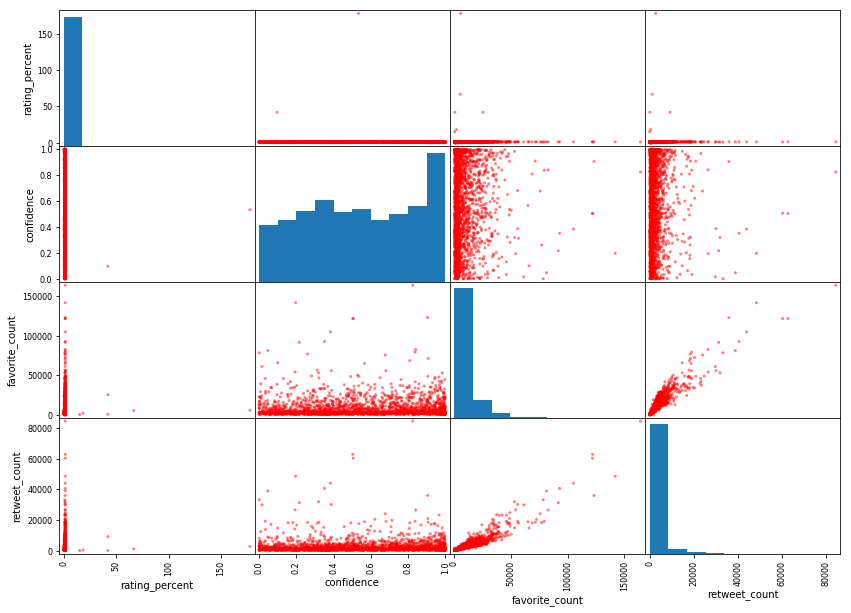

In [100]:
#Scatter Matrix
pd.plotting.scatter_matrix(twitter_archive_master.drop(['tweet_id','img_num','rating_numerator','rating_denominator','retweeted','user_replied_tweet'], axis = 1), alpha = 0.5,
              figsize = (14,10), diagonal = 'hist', color = 'red',)
plt.show()

- Correlation between **favorite_count** and **retweet_count** columns is visible.

In [101]:
#Taking log transformation
twitter_archive_master_log = np.log(twitter_archive_master[['rating_percent', 'confidence', 'favorite_count', 'retweet_count']] + 1)

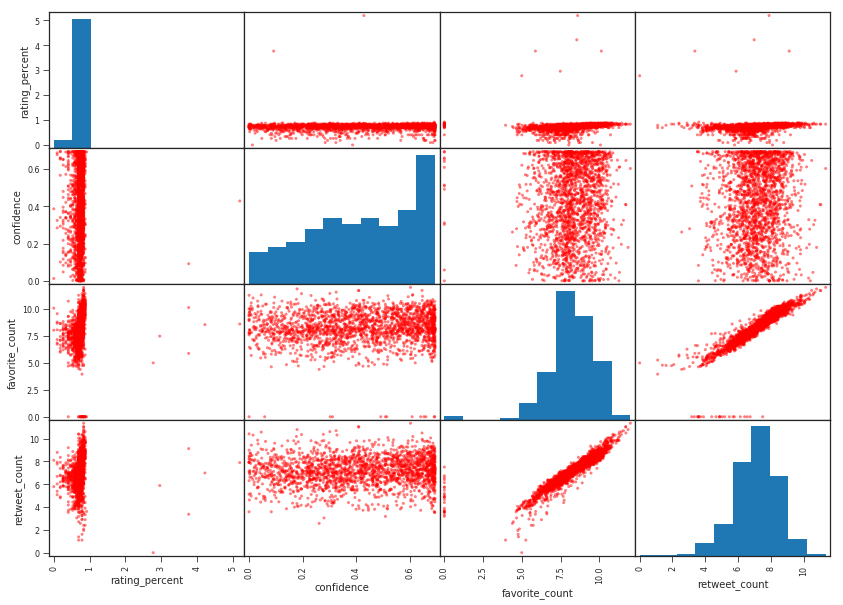

In [115]:
pd.plotting.scatter_matrix(twitter_archive_master_log, alpha = 0.5,figsize = (14,10), diagonal = 'hist', color = 'red')
plt.show()

- Correlation between **favorite_count** and **retweet_count** columns is more highly visible.
- Correlation between few other variables is visible through log transformation but its very less.(**favorite_count, retweet_count vs rating_percent**)

Text(0.5,1,'Correlation Map')

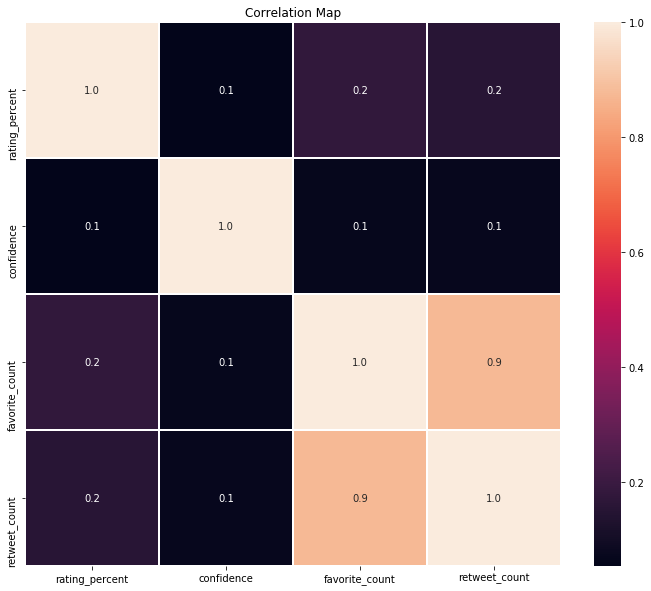

In [103]:
f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(twitter_archive_master_log.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Map')

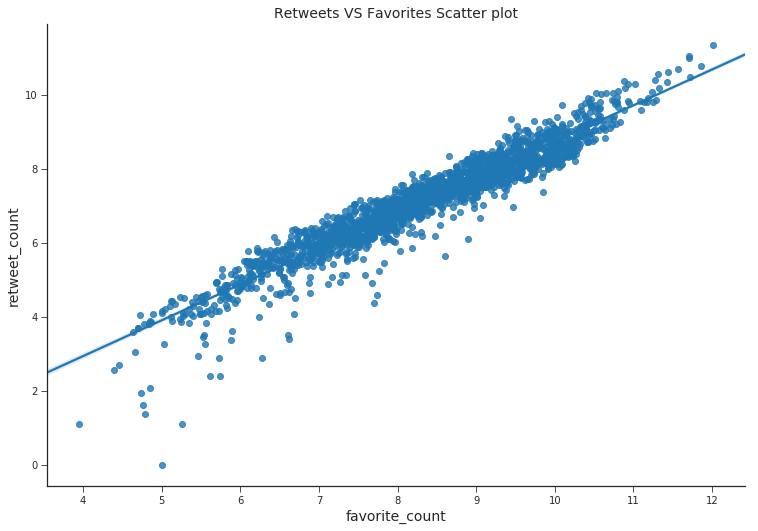

In [104]:
#Linear regression sns plot on favorite_count vs retweet_count
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 8.5)
plt.xlabel('Favorite count', fontsize = 14)
plt.ylabel('Retweeted Count', fontsize = 14)
plt.title('Retweets VS Favorites Scatter plot', fontsize = 14)
sns.regplot(x="favorite_count", y="retweet_count", data=twitter_archive_master_log.query("favorite_count != 0"));
sns.despine()


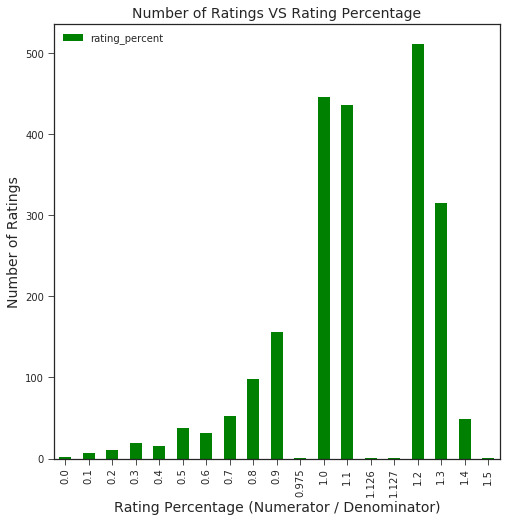

In [105]:
#Plot to determine the number of ratings for each score rating by @weratedogs..
twitter_archive_master.rating_percent.value_counts().sort_index().reset_index()[:-5].plot(kind = 'bar', x = 'index', y = 'rating_percent', figsize = (8,8), color = 'green');
plt.xlabel('Rating Percentage (Numerator / Denominator)', fontsize = 14);
plt.ylabel('Number of Ratings', fontsize = 14);
plt.title('Number of Ratings VS Rating Percentage', fontsize = 14);

In [106]:
#Overall percentage share of each dog stage in our data.
pd.DataFrame(twitter_archive_master.dog_stage.value_counts()/twitter_archive_master.dog_stage.value_counts().sum() * 100).rename(columns = {'dog_stage':'Ratio of Dogs in %'}).sort_index()

,Ratio of Dogs in %
doggo,25.000000
floofer,2.586207
pupper,65.517241
puppo,6.896552


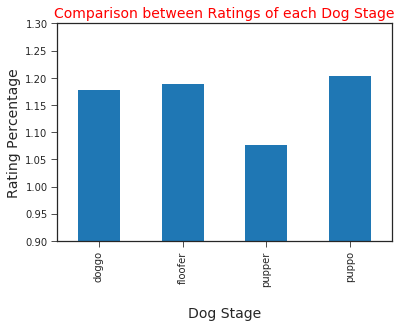

In [107]:
#Plotting overall average rating score for each dog stage. Here we are taking rating scores percent below 2..
twitter_archive_master.query("rating_percent > 0 & rating_percent < 2").groupby('dog_stage').mean().sort_index().rating_percent.plot(kind = 'bar', ylim = (0.9 , 1.3));
plt.xlabel("Dog Stage", fontsize = 14, labelpad=20);
plt.ylabel('Rating Percentage', fontsize = 14);
plt.title('Comparison between Ratings of each Dog Stage', fontsize = 14, color = 'red');

- We see here puppo hold first place followed by floofer and doggo. They are all marginally close to each other.

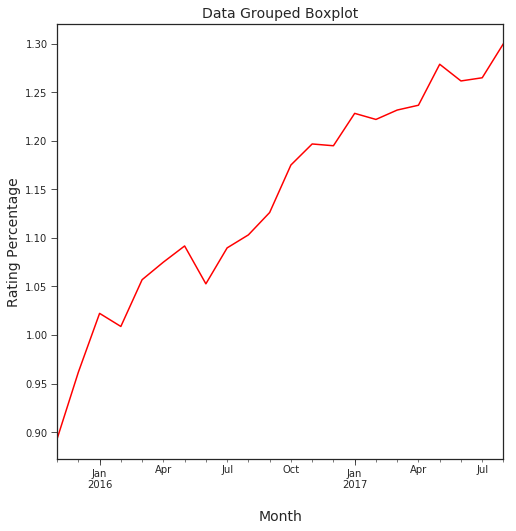

In [119]:
#Plot of avg rating per month over the entire data collected period.. Here we are taking rating scores percent below 2..
twitter_archive_master.query("rating_percent > 0 & rating_percent < 1.5").set_index('timestamp').groupby(pd.TimeGrouper('M')).mean().rating_percent.dropna().plot(figsize = (8,8), color = 'red');
plt.xlabel("Month", fontsize = 14, labelpad=20);
plt.ylabel('Rating Percentage', fontsize = 14);
plt.title('Data Grouped Boxplot', fontsize = 14);

In [109]:
values = {'date':[], 'rating_percent':[]}

In [110]:
for i in twitter_archive_master.timestamp.dt.date:
    values['date'].append(i)
for i in twitter_archive_master.rating_percent:
    values['rating_percent'].append(i)

In [111]:
box_plt_df = pd.DataFrame(values)
box_plt_df.date = pd.to_datetime(box_plt_df.date).dt.to_period('M')
box_plt_df.sort_values('date',inplace = True)

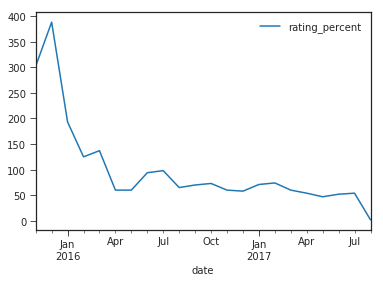

In [112]:
#Plot of number of ratings given by @weratedogs through each month month..
box_plt_df.groupby('date').count().plot()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


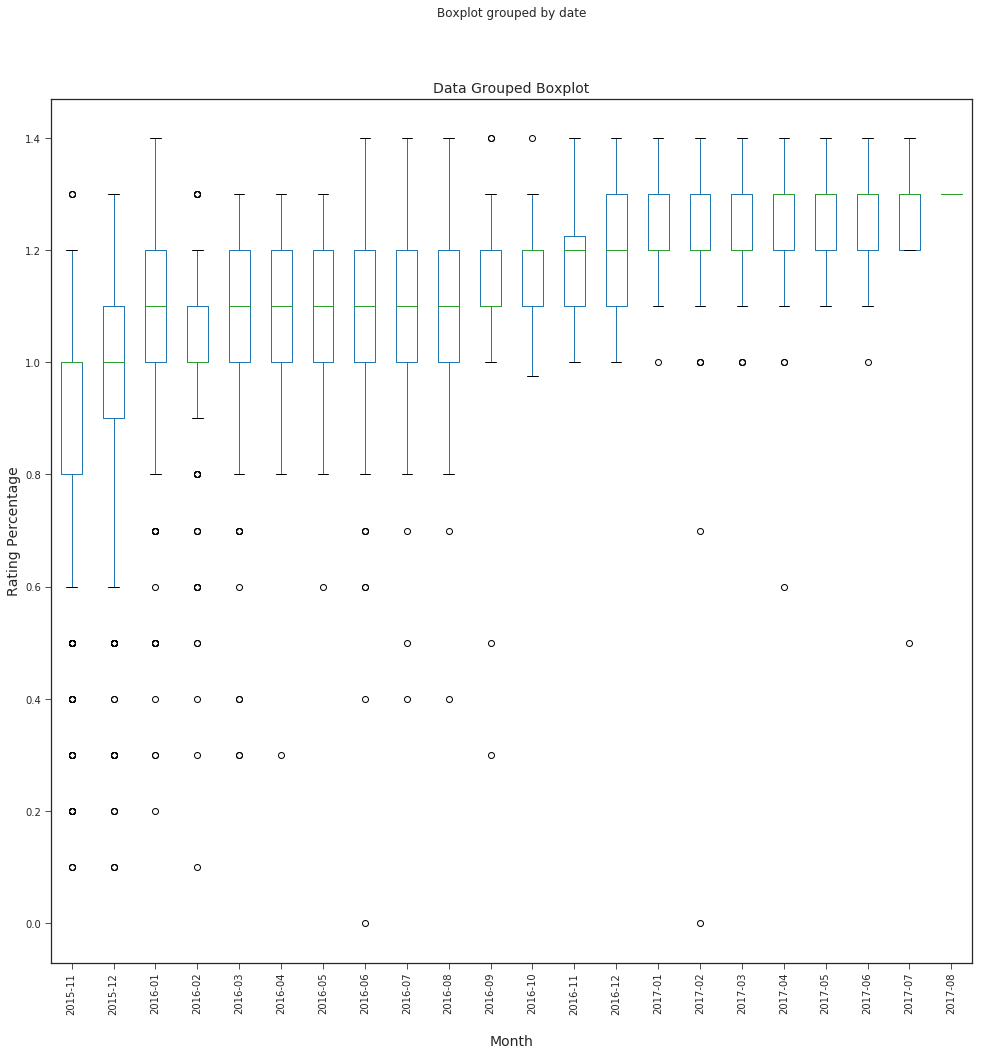

In [117]:
#Box plot of rating score as a percentage through each month..  Here we are taking rating scores percent below 1.5..
box_plt_df[box_plt_df.rating_percent < 1.5].boxplot(column = 'rating_percent', by = 'date', grid = False, figsize = (16,16))
plt.xlabel("Month", fontsize = 14, labelpad=20)
plt.ylabel('Rating Percentage', fontsize = 14)
plt.title('Data Grouped Boxplot', fontsize = 14)
plt.xticks(rotation='vertical')
plt.show()

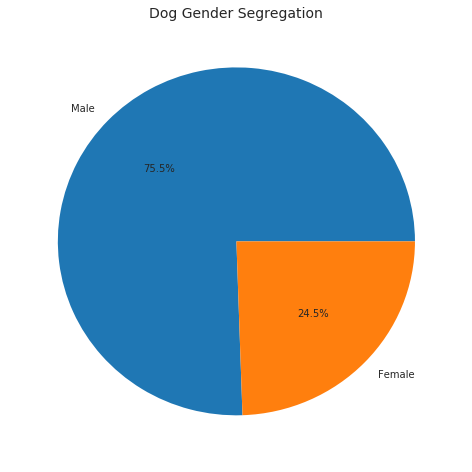

In [114]:
# Plot the data partitioned by dog gender
twitter_archive_master['dog_gender'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize = (8,8), fontsize = 10);
plt.xlabel("", fontsize = 14, labelpad=20);
plt.ylabel('', fontsize = 14);
plt.title('Dog Gender Segregation', fontsize = 14);